In [1]:
import warnings
warnings.filterwarnings('ignore')
import keras
import glob
from tqdm import *
import os
import cv2
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

In [2]:
num_classes = 42

In [3]:
train_dirs = glob.glob("dataset_2/*")
train_dirs.sort()
train_dirs = train_dirs[:num_classes]
# print(len(train_dirs))

# print(train_dirs)
data = []
labels = []
for train_dir in tqdm(train_dirs):
  imgPaths = glob.glob(train_dir + "/*.jpg")
  imgPaths.sort()
  for imgPath in tqdm(imgPaths):
    image = load_img(imgPath, target_size=(28, 28), grayscale=True)
    image = img_to_array(image) 
    data.append(image)

    label = imgPath.split(os.path.sep)[-2]
#     print(label)
    label = int(label)
    labels.append(label)

100%|██████████| 42/42 [01:01<00:00,  1.47s/it]


In [4]:
print(len(data), len(labels))


82288 82288


In [5]:
data = np.array(data, dtype=np.float) / 255.
labels = np.array(labels)

In [6]:
from sklearn.model_selection import train_test_split
train_input, valid_input, train_target, valid_target = train_test_split(data,
                                                                        labels,
                                                                        test_size=0.25,
                                                                        random_state=123)

In [7]:
from keras.utils import to_categorical
train_target = to_categorical(train_target, num_classes=num_classes)
valid_target = to_categorical(valid_target, num_classes=num_classes)


In [8]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=10, width_shift_range=0.25, height_shift_range=0.25 , zoom_range=0.25)

In [9]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense , BatchNormalization ,Activation
from keras.models import Model
def build_model(inputs):
    
  x = inputs

  x = Conv2D(filters=20, kernel_size=(5, 5), padding="same", activation="relu")(x)
  x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

  x = Conv2D(filters=50, kernel_size=(5, 5), padding="same", activation="relu" )(x)
    
  x = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(x)
  x = BatchNormalization(axis = 3, name = 'bn0')(x)
  x = Activation('relu')(x)

  x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x) 

  x = Flatten()(x)
  x = Dense(500, activation="relu")(x)
  outputs = Dense(num_classes, activation="softmax")(x)

  model = Model(inputs, outputs, name="LeNet")
  model.summary()
  
  return model

In [16]:
pwd

'/home/hossein/cv_project'

In [13]:
from keras.layers import Input
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
# import tensorflow as tf

EPOCHS = 20
BS = 32

input = Input((28, 28, 1))
model = build_model(input)

checkpoint_filepath = '/home/hossein/cv_project/tmp/checkpoint'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_acc',
#     mode='max',
#     save_best_only=True)

opt = Adam()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["acc"])



training_log = model.fit(train_input, train_target, validation_data=(valid_input, valid_target), epochs=EPOCHS, batch_size=BS)


Model: "LeNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
conv0 (Conv2D)               (None, 12, 12, 32)        14432     
_________________________________________________________________
bn0 (BatchNormalization)     (None, 12, 12, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 12, 12, 32)        0     

In [17]:
from keras.models import load_model
model = load_model('BatchNorm_87.h5')
model.summary()
scores = model.evaluate(valid_input, valid_target, verbose=0)
print("Test Acc: %.2f%%" % (scores[1]*100))
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Model: "LeNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
conv0 (Conv2D)               (None, 12, 12, 32)        14432     
_________________________________________________________________
bn0 (BatchNormalization)     (None, 12, 12, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 12, 12, 32)        0     

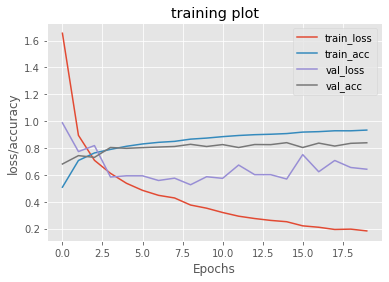

In [15]:
model.save("BatchNorm_83.h5")
from matplotlib import pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(EPOCHS), training_log.history["loss"], label="train_loss")
plt.plot(np.arange(EPOCHS), training_log.history["acc"], label="train_acc")
plt.plot(np.arange(EPOCHS), training_log.history["val_loss"], label="val_loss")
plt.plot(np.arange(EPOCHS), training_log.history["val_acc"], label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("loss/accuracy")
plt.title("training plot")
plt.legend(loc="middle right")
plt.savefig("training_plot.png")

85


ValueError: num must be 1 <= num <= 50, not 51

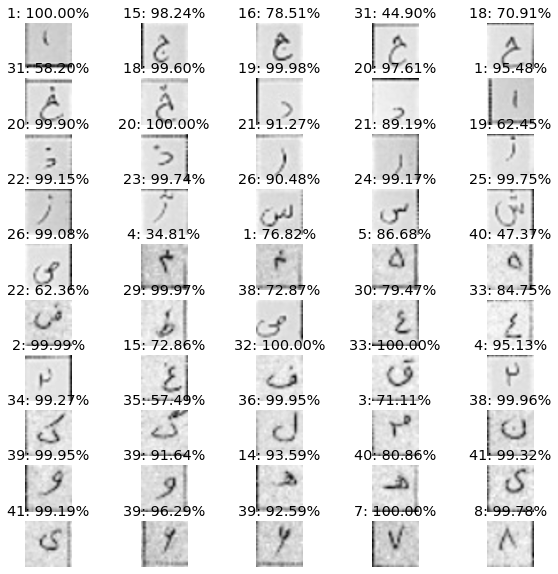

In [16]:
# model.load_weights("BatchNorm_81.h5")
testPaths = glob.glob("vision_final_prj/test_imgs/*.jpg")
testPaths.sort()
print(len(testPaths))
plt.figure(figsize=(10, 10))
for i, testPath in enumerate(testPaths):
    image = load_img(testPath, target_size=(28, 28), grayscale=True)
    image = img_to_array(image) / 255.
    orig_img = image.copy()
    image = np.expand_dims(image, 0)
    predictions = model.predict(image)[0]
    label = np.argmax(predictions)
    proba = np.max(predictions)
    output = cv2.resize(orig_img, (400, 400))
    plt.subplot(10, 5, i + 1)
    plt.imshow(output, cmap="gray")
    plt.axis("off")
    plt.title("{}: {:.2f}%".format(label, proba * 100))